In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [18]:
df = pd.read_csv('https://s3.amazonaws.com/projects-rf/clean_data.csv')

In [19]:
df.to_csv("rf_data.csv")

In [20]:
RSEED = 50

# Load in data
df = pd.read_csv('rf_data.csv')

In [21]:
print(df.head())
print(df.shape)

   Unnamed: 0  _STATE  FMONTH  DISPCODE         SEQNO          _PSU  CTELENUM  \
0           0    49.0     4.0    1100.0  2.015009e+09  2.015009e+09       NaN   
1           1     9.0     9.0    1100.0  2.015005e+09  2.015005e+09       1.0   
2           2    34.0    10.0    1100.0  2.015011e+09  2.015011e+09       NaN   
3           3    41.0     4.0    1100.0  2.015002e+09  2.015002e+09       1.0   
4           4    54.0     5.0    1100.0  2.015004e+09  2.015004e+09       NaN   

   PVTRESD1  COLGHOUS  STATERES  ...  _PAREC1  _PASTAE1  _LMTACT1  _LMTWRK1  \
0       NaN       NaN       NaN  ...      4.0       2.0       3.0       3.0   
1       1.0       NaN       1.0  ...      2.0       2.0       3.0       3.0   
2       NaN       NaN       NaN  ...      4.0       2.0       3.0       3.0   
3       1.0       NaN       1.0  ...      2.0       2.0       2.0       2.0   
4       NaN       NaN       NaN  ...      1.0       1.0       3.0       3.0   

   _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSH

In [22]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.3, 
                                         random_state = RSEED)

In [23]:
# Imputation of missing values
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)

In [38]:
from sklearn import tree
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

#model = tree.DecisionTreeClassifier(min_samples_leaf=5, max_depth=3)

# Fit on training data
model.fit(train, train_labels)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [39]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

AttributeError: 'DecisionTreeClassifier' object has no attribute 'estimators_'

In [40]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

Recall Baseline: 1.0 Test: 0.96 Train: 0.96
Precision Baseline: 0.81 Test: 0.87 Train: 0.87
Roc Baseline: 0.5 Test: 0.8 Train: 0.81


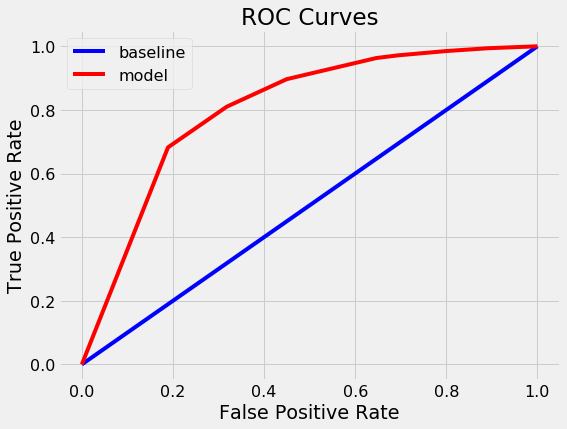

In [41]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
#plt.savefig('roc_auc_curve.png')



Confusion matrix, without normalization
[[ 1972  3602]
 [  900 23442]]


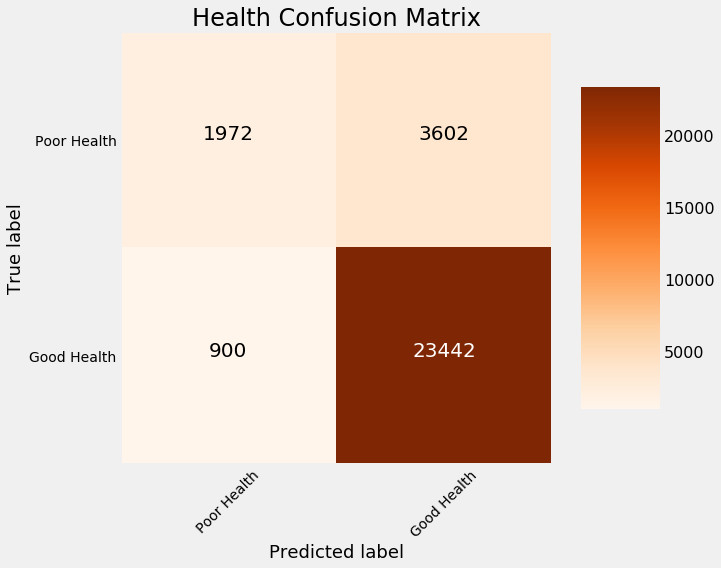

In [42]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

#plt.savefig('cm.png')

In [43]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("%s. feature %d (%f)" % (train.columns[f] , indices[f], importances[indices[f]]))



AttributeError: 'DecisionTreeClassifier' object has no attribute 'estimators_'

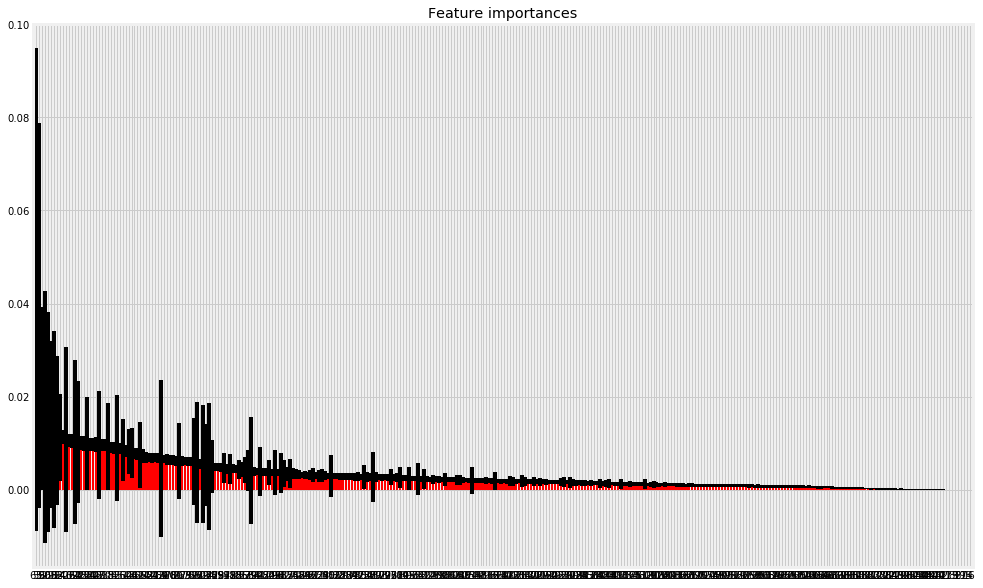

In [37]:
# Plot the impurity-based feature importances of the forest
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()